In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime
import json 
from scipy import stats
from scipy.stats import linregress
from config import weather_api_key
#from config import g_key
from citipy import citipy
csvfile = "Buoy Stations - Sheet1.csv" 

In [2]:
buoy_df_raw = pd.read_csv(csvfile)
buoy_df = buoy_df_raw.dropna()
buoy_df.head()

,Buoy,Lat,Long
0,42002,26.055,-93.646
1,42003,25.925,-85.615
2,khhv,26.939,-94.689
3,kemk,27.819,-94.323
4,42019,27.910,-95.345


In [3]:
lat_val = []
lng_val = []
for index,row in buoy_df.iterrows():
    lat_val.append(row["Lat"])
    lng_val.append(row["Long"])

In [4]:
#set function to get today and previous 4 days' weather data
def unix_time():
    today = datetime.date.today()
    days = [1,2,3,4]
    times = [int(time.mktime(today.timetuple()))]
    for day in days:
        x=today - datetime.timedelta(days=day)
        unixtime = int(time.mktime(x.timetuple()))
        times.append(unixtime)
    return (times)

In [5]:
#lists for buoy data dataframe
hour_temp =[]
hour_pressure =[]
hour_wind_speed =[]
hour_wind_deg =[]
hour_time=[]
hour_lat=[]
hour_lng = []

In [6]:
for lat in range(len(lat_val)):
    for x in unix_time():
            historical_url = f"http://api.openweathermap.org/data/2.5/onecall/timemachine?lat={lat_val[lat]}&lon={lng_val[lat]}&dt={x}&appid={weather_api_key}&units=imperial"
            hist_json = requests.get(historical_url).json()
            for i in range((len(hist_json["hourly"]))):
                hour_temp.append(hist_json["hourly"][i]["temp"])
                hour_pressure.append(hist_json["hourly"][i]["pressure"])
                hour_wind_speed.append(hist_json["hourly"][i]["wind_speed"])
                hour_wind_deg.append(hist_json["hourly"][i]["wind_deg"])
                hour_time.append(hist_json["hourly"][i]["dt"])
                hour_lat.append(hist_json["lat"])
                hour_lng.append(hist_json["lon"])
      
        

In [7]:
buoy_dict = {"Lat":hour_lat,
            "Long":hour_lng,
            "Temp":hour_temp,
            "Pressure":hour_pressure,
            "Wind_Speed":hour_wind_speed,
            "Wind_Degrees":hour_wind_deg,
            "Unix Time":hour_time}
buoy_output_data = pd.DataFrame(buoy_dict)
buoy_output_data

,Lat,Long,Temp,Pressure,Wind_Speed,Wind_Degrees,Unix Time
0,26.055,-93.646,85.14,1012,7.16,56,1630972800
1,26.055,-93.646,84.94,1012,8.30,70,1630976400
2,26.055,-93.646,84.99,1012,9.55,89,1630980000
3,26.055,-93.646,84.88,1013,10.42,100,1630983600
4,26.055,-93.646,84.76,1013,10.76,111,1630987200
...,...,...,...,...,...,...,...
4546,21.030,-64.790,83.68,1015,13.94,88,1630695600
4547,21.030,-64.790,83.77,1015,14.29,86,1630699200
4548,21.030,-64.790,83.66,1015,14.23,86,1630702800
4549,21.030,-64.790,83.46,1015,14.81,88,1630706400


In [8]:
buoy_output_data.to_csv("./CSV_Output/buoy_data.csv", index=False)

In [9]:
#set "cit center" for Houston
Houston_lat = 29.756097853207656
Houston_lng = -95.3669907972107


#calculate greater Houston area by expanding lat and lng
lat = np.random.uniform(Houston_lat-1, Houston_lat+2, size=6500)
lng = np.random.uniform(Houston_lng-5, Houston_lng+2, size=6500)
city = []

#find nearest city using lat and lng
for x in range(len(lat)):
    city.append(citipy.nearest_city(lat[x], lng[x]).city_name)


In [10]:
#turn cities into df
df_city = pd.DataFrame({
    "City":city,
    "lat":lat,
    "lng":lng,
})

In [11]:
df_city

,City,lat,lng
0,brownwood,31.259100,-99.247320
1,baytown,29.626060,-94.741412
2,pleasanton,29.132606,-98.732959
3,victoria,29.068931,-97.512736
4,galveston,28.874112,-93.887206
...,...,...,...
6495,robinson,31.496172,-96.675021
6496,freeport,28.986643,-95.300281
6497,leander,30.763868,-98.152045
6498,bellmead,31.610844,-96.923854


In [12]:
#check length of cities
# len(list(df_city["City"].unique()))

In [13]:
cities = list(df_city["City"].unique())
target_cities=[]

for i in cities:
    c=str(i).replace(" ","+")
    target_cities.append(c)

In [14]:
#set base url and define function to find OpenWeather cities' based on city name from nearest place API and feed back into
#OpenWeather one call API to ensure proper lat and lng

def find_location(target_cities):
    unix_time()
    base_current_url = "http://api.openweathermap.org/data/2.5/weather?"
    hour_temp_city =[]
    hour_pressure_city =[]
    hour_wind_speed_city =[]
    hour_wind_deg_city=[]
    hour_time_city=[]
    city_name=[]
    for city in target_cities:
        try: 
            query_url=f"{base_current_url}appid={weather_api_key}&q={city},Texas,USA&units=imperial"
            req = requests.get(query_url)
            response1=req.json()
            latitude=response1["coord"]["lat"]
            longitude=response1["coord"]["lon"]

        except:
            print("City not found. Skipping...")
            pass
        if response1["sys"]["country"]=="US":
            for x in unix_time():
                historical_url = f"http://api.openweathermap.org/data/2.5/onecall/timemachine?lat={latitude}&lon={longitude}&dt={x}&appid={weather_api_key}&units=imperial"
                hist_json = requests.get(historical_url).json()
                for i in range(len(hist_json["hourly"])):
                    hour_temp_city.append(hist_json["hourly"][i]["temp"])
                    hour_pressure_city.append(hist_json["hourly"][i]["pressure"])
                    hour_wind_speed_city.append(hist_json["hourly"][i]["wind_speed"])
                    hour_wind_deg_city.append(hist_json["hourly"][i]["wind_deg"])
                    hour_time_city.append(hist_json["hourly"][i]["dt"])
                    city_name.append(response1["name"])
                
    d=dict()
    d["City Name"] = city_name
    d["Temperature"] = hour_temp_city
    d["Pressure"] = hour_pressure_city
    d["Wind Degrees"]=hour_wind_deg_city
    d["Wind_Speed"] = hour_wind_speed_city
    return(d)

In [15]:
df2 =pd.DataFrame(find_location(target_cities))

In [16]:
df2

,City Name,Temperature,Pressure,Wind Degrees,Wind_Speed
0,Brownwood,86.25,1014,170,16.11
1,Brownwood,80.71,1015,180,8.05
2,Brownwood,77.34,1015,140,4.61
3,Brownwood,75.79,1016,0,0.00
4,Brownwood,74.26,1016,0,0.00
...,...,...,...,...,...
10651,South Houston,88.39,1014,0,0.00
10652,South Houston,82.00,1014,70,12.66
10653,South Houston,81.00,1015,170,11.50
10654,South Houston,79.66,1013,170,5.75


In [17]:
df2.to_csv("./CSV_Output/city_data.csv", index=False)

In [21]:
#Identify the weather conditions in Bouy 

buoy_output_data["Storm_Category_Wind"] = ["NA" if x <=40 else "TS" if x <=55 else "LS" if x <=70 else "HU" for x in buoy_output_data["Wind_Speed"]]
buoy_output_data["Storm_Category_Pressure"] = ["NA" if x >=1008 else "TS" if x >=990 else "LS" if x >=950 else "HU" for x in buoy_output_data["Pressure"]]
buoy_output_data

,Lat,Long,Temp,Pressure,Wind_Speed,Wind_Degrees,Unix Time,Storm_Category,Storm_Category_P,Storm_Category_Wind,Storm_Category_Pressure
0,26.055,-93.646,85.14,1012,7.16,56,1630972800,NA,NA,NA,NA
1,26.055,-93.646,84.94,1012,8.30,70,1630976400,NA,NA,NA,NA
2,26.055,-93.646,84.99,1012,9.55,89,1630980000,NA,NA,NA,NA
3,26.055,-93.646,84.88,1013,10.42,100,1630983600,NA,NA,NA,NA
4,26.055,-93.646,84.76,1013,10.76,111,1630987200,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...
4546,21.030,-64.790,83.68,1015,13.94,88,1630695600,NA,NA,NA,NA
4547,21.030,-64.790,83.77,1015,14.29,86,1630699200,NA,NA,NA,NA
4548,21.030,-64.790,83.66,1015,14.23,86,1630702800,NA,NA,NA,NA
4549,21.030,-64.790,83.46,1015,14.81,88,1630706400,NA,NA,NA,NA


In [22]:
#Identify the weather conditions in Houston region

city_df2 = pd.read_csv("CSV_Output/city_data.csv")
city_df2["Storm_Category_Wind"] = ["NA" if x <=40 else "TS" if x <=55 else "LS" if x <=70 else "HU" for x in city_df2["Wind_Speed"]]
city_df2["Storm_Category_Pressure"] = ["NA" if x >=1008 else "TS" if x >=990 else "LS" if x >=950 else "HU" for x in city_df2["Pressure"]]
city_df2

,City Name,Temperature,Pressure,Wind Degrees,Wind_Speed,Storm_Category_Wind,Storm_Category_Pressure
0,Brownwood,86.25,1014,170,16.11,NA,NA
1,Brownwood,80.71,1015,180,8.05,NA,NA
2,Brownwood,77.34,1015,140,4.61,NA,NA
3,Brownwood,75.79,1016,0,0.00,NA,NA
4,Brownwood,74.26,1016,0,0.00,NA,NA
...,...,...,...,...,...,...,...
10651,South Houston,88.39,1014,0,0.00,NA,NA
10652,South Houston,82.00,1014,70,12.66,NA,NA
10653,South Houston,81.00,1015,170,11.50,NA,NA
10654,South Houston,79.66,1013,170,5.75,NA,NA


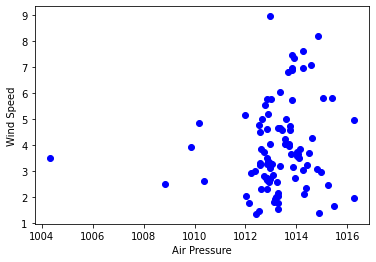

In [34]:

x_values = city_df2.groupby("City Name").mean()["Pressure"]
y_values = city_df2.groupby("City Name").mean()["Wind_Speed"]

plt.scatter(x_values,y_values,color="blue")
plt.xlabel('Air Pressure')
plt.ylabel('Wind Speed')

plt.show()